# SOLAQUA dataprocessing 

Here we convert "raw"-.bag files into desired sonar images. They are also exported

## (Optional) List Topics

In [3]:
from collections import defaultdict 
from rosbags.highlevel import AnyReader
from pathlib import Path
import numpy as np
import cv2
import re

# Change these two lines to switch dataset
DATA_BAG  = Path("data/bags/2024-08-20_17-14-36_data.bag")   # sensor data
VIDEO_BAG = Path("data/bags/2024-08-20_17-14-36_video.bag")  # camera and sonar video
VIDEO_FRAME = 0

print(f"Using data bag : {DATA_BAG.resolve()}")
print(f"Using video bag: {VIDEO_BAG.resolve()}")




def human_hz(count, duration_s):
    if count == 0 or duration_s <= 0:
        return 0.0
    return count / duration_s

for bag in [DATA_BAG, VIDEO_BAG]:
    print(f"\n=== {bag.name} ===")
    if not bag.exists():
        print("  (missing)")
        continue

    counts = defaultdict(int)
    first_ts = defaultdict(lambda: None)
    last_ts  = defaultdict(lambda: None)
    types = {}

    with AnyReader([bag]) as r:
        for c in r.connections:
            types[c.topic] = c.msgtype
        for conn, ts, _ in r.messages():
            t = conn.topic
            counts[t] += 1
            if first_ts[t] is None or ts < first_ts[t]:
                first_ts[t] = ts
            if last_ts[t] is None or ts > last_ts[t]:
                last_ts[t] = ts

    if not counts:
        print("  (no messages)")
        continue

    col_topic = max(len(t) for t in counts.keys())
    col_type  = max(len(types.get(t, "")) for t in counts.keys())
    header = f"{'TOPIC'.ljust(col_topic)}  {'TYPE'.ljust(col_type)}  COUNT    START(ns)          END(ns)            DURATION(s)  ~HZ"
    print(header)
    print("-" * len(header))

    for t in sorted(counts.keys()):
        n = counts[t]
        t0 = first_ts[t]
        t1 = last_ts[t]
        dur_s = (t1 - t0) / 1e9 if (t0 is not None and t1 is not None) else 0.0
        hz = human_hz(n, dur_s)
        print(
            f"{t.ljust(col_topic)}  "
            f"{types.get(t,'').ljust(col_type)}  "
            f"{str(n).rjust(5)}    "
            f"{str(t0).rjust(16)}  "
            f"{str(t1).rjust(16)}  "
            f"{dur_s:11.3f}  {hz:5.2f}"
        )

Using data bag : /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/bags/2024-08-20_17-14-36_data.bag
Using video bag: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/bags/2024-08-20_17-14-36_video.bag

=== 2024-08-20_17-14-36_data.bag ===
TOPIC                                     TYPE                                     COUNT    START(ns)          END(ns)            DURATION(s)  ~HZ
--------------------------------------------------------------------------------------------------------------------------------------------------
/bluerov2/alive                           std_msgs/msg/Float32                        99    1724166879139572100  1724166927966070000       48.826   2.03
/bluerov2/armed                           std_msgs/msg/Float32                        93    1724166882123753100  1724166927966127900       45.842   2.03
/bluerov2/battery                         messages/msg/BatteryStatus                  43    1724166883701664800  1724166927391126900       43.689   0.98
/bluerov2/mo

# Sonar data processing

What we want is raw sonar data processed to RGB images (and later grayscale that looks similar to cfc_gray).

### Setup 

In [4]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict
import hashlib
import json

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from configs.cfc_gray_config import cfc_gray_config


SONAR_IMAGES_CONFIG = cfc_gray_config



### Load data

In [6]:
from pathlib import Path
from utils.loader import load_sonoptix_frame_from_bag

DATA_BAG  = Path("data/bags/2024-08-20_17-14-36_data.bag")   
VIDEO_BAG = Path("data/bags/2024-08-20_17-14-36_video.bag")  
VIDEO_FRAME = 500

M_raw, t_ns = load_sonoptix_frame_from_bag(VIDEO_BAG, VIDEO_FRAME)  # returns M_raw and timestamp
print("loaded:", M_raw.shape, M_raw.dtype, ". min..max:", float(M_raw.min()), float(M_raw.max()))
print("M_raw:")
print(M_raw)
print("timestamp: ", t_ns)  

loaded: (1024, 256) float32 . min..max: 0.0 59.0
M_raw:
[[ 2.  3.  4. ...  7.  6.  4.]
 [ 5.  6.  6. ... 12. 12. 10.]
 [ 5.  6.  5. ... 13. 13. 11.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
timestamp:  1724166911619278700



#### Plot raw and enhanced data, Polar from

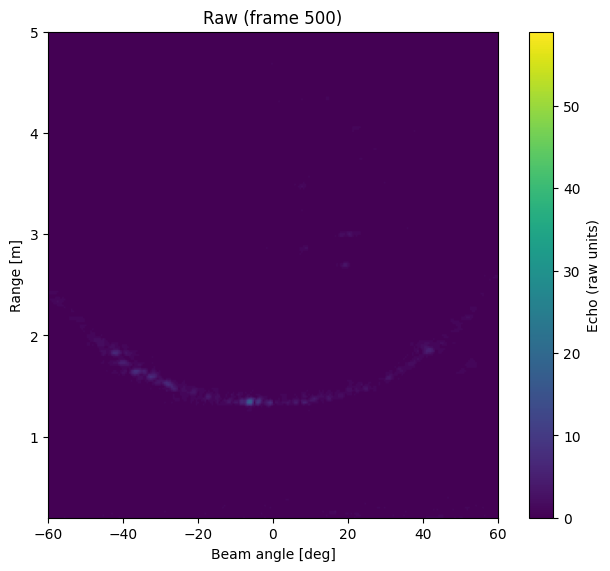

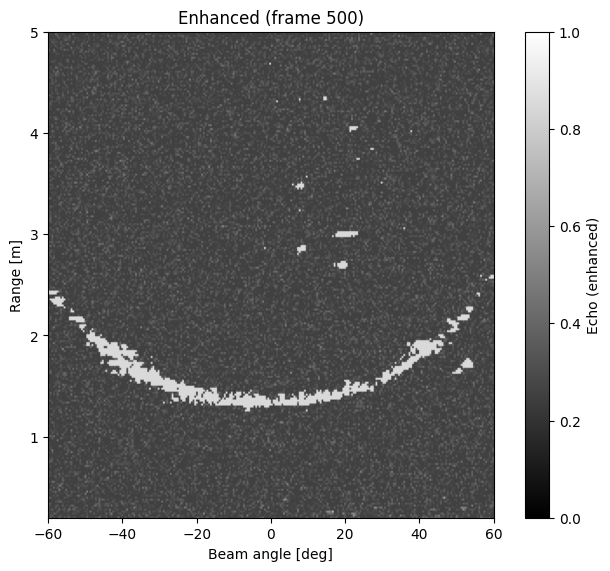

In [7]:
from utils.sonar_visualization import plot_raw_frame, plot_enhanced_frame, enhance_intensity, enhance_cfc_style


# fig = plot_raw_and_enhanced(M_raw, VIDEO_FRAME, SONAR_VIS_DEFAULTS)
fig1 = plot_raw_frame(M_raw, VIDEO_FRAME, SONAR_IMAGES_CONFIG)
fig2 = plot_enhanced_frame(M_raw, VIDEO_FRAME, SONAR_IMAGES_CONFIG, enhancer=enhance_cfc_style)
plt.show()


### Plot Cone display

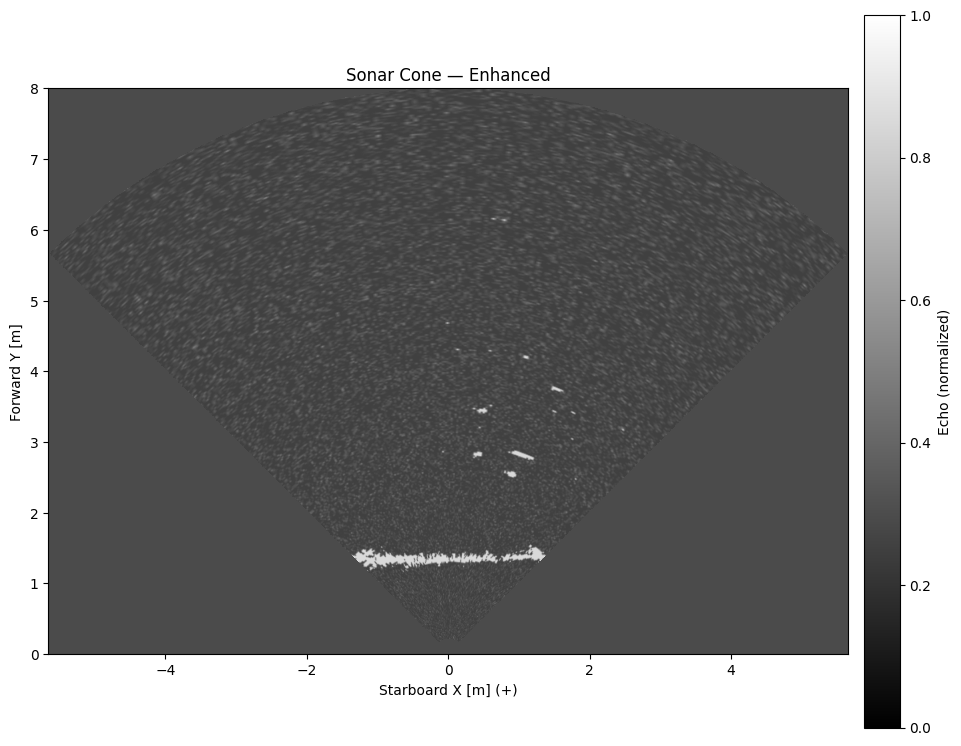

In [8]:
from utils.sonar_visualization import plot_cone_view, enhance_intensity, enhance_cfc_style


fig_cone = plot_cone_view(
    M_raw, 
    SONAR_IMAGES_CONFIG,
    use_enhanced=True,
    enhancer=enhance_cfc_style,   
)
plt.show()


# Export data (remember to set output name)



In [7]:
# from utils.sonar_visualization import save_cone_view_image, enhance_cfc_style

# save_cone_view_image(
#     M_raw,
#     SONAR_IMAGES_CONFIG,
#     out_path="exports/sonar/001_frame.png",
#     use_enhanced=True,
#     enhancer=enhance_cfc_style,
# )


### exporting all images

In [9]:
from pathlib import Path
from utils.loader import load_sonoptix_frame_from_bag
from utils.sonar_visualization import save_cone_view_image, enhance_cfc_style
import numpy as np
from tqdm import tqdm

# ----------------------------
# SETTINGS
# ----------------------------
bag_stem = VIDEO_BAG.stem.replace("_video", "")

OUT_DIR = Path("data/exports/sonar") / bag_stem / "cfc_style" / "images"  ## CHANGE HERE after bag_stem


# Range of frames to export
START_FRAME = 0
END_FRAME   = 769     # change this to however many frames your bag has
STEP        = 1

# Enhancer to use
ENHANCER = enhance_cfc_style

# Your sonar config dict
CFG = SONAR_IMAGES_CONFIG
# ----------------------------


OUT_DIR.mkdir(parents=True, exist_ok=True)

for frame_idx in tqdm(range(START_FRAME, END_FRAME, STEP), desc="Exporting frames"):

    try:
        M_raw, t_ns = load_sonoptix_frame_from_bag(VIDEO_BAG, frame_idx)
    except Exception as e:
        tqdm.write(f"⚠️ Could not load frame {frame_idx}: {e}")
        continue

    # skip empty frames
    if M_raw is None or not isinstance(M_raw, np.ndarray):
        tqdm.write(f"⚠️ Empty frame {frame_idx}")
        continue

    # Output filename = timestamp
    out_path = OUT_DIR / f"{t_ns}.jpg"


    save_cone_view_image(
        M_raw,
        CFG,
        out_path=out_path,
        use_enhanced=True,
        enhancer=ENHANCER,
    )

print("✅ Finished exporting all frames.")


Exporting frames: 100%|██████████| 769/769 [07:19<00:00,  1.75it/s]

✅ Finished exporting all frames.


### making mp4 from images

We are using Variable frame rate (VFR) and the ffmpeg library.

Was a bit tricky to get the ffmpeg dependency. I did module load Anaconda3/2024.02-1, then conda --version to confirm. Then conda create -n myffmpeg -c conda-forge ffmpeg -y to install ffmpeg. conda activate myffmpeg and ffmpeg -version to confirm. To load it into the .venv i did: source .venv/bin/activate and then export PATH="$HOME/.conda/envs/myffmpeg/bin:$PATH". Lastly select kernel with the python enviornment (.venv).

To activate environments next time do:
- module load Anaconda3/2024.02-1
- source .venv/bin/activate
- export PATH="$HOME/.conda/envs/myffmpeg/bin:$PATH"
- select right kernel

- if kernel cant find ffmpeg, do this inside notebook:
```python

```

In [4]:
import os
os.environ["PATH"] = "/cluster/home/henrban/.conda/envs/myffmpeg/bin:" + os.environ["PATH"]
!ffmpeg -version

ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
built with gcc 14.3.0 (conda-forge gcc 14.3.0-5)
configuration: --prefix=/cluster/home/henrban/.conda/envs/myffmpeg --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1758923993009/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1758923993009/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1758923993009/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1758923993009/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-alsa --enable-libpulse --enable-libvpl --enable-vaapi --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx

In [5]:
from utils.sonar_visualization import build_vfr_mp4_from_ns_frames


#VIDEO_BAG = Path("data/bags/2024-08-20_13-57-42_video.bag")     # bag should be defined in the top
bag_stem  = VIDEO_BAG.stem.replace("_video", "")
sonar_frames = Path(f"data/exports/sonar/{bag_stem}/cfc_style/predictions")
sonar_out    = Path(f"data/exports/sonar/{bag_stem}/cfc_style/{bag_stem}_cfc_style.mp4")   ## change output name if you want to

build_vfr_mp4_from_ns_frames(sonar_frames, sonar_out, crf=18, preset="slow")

Running: ffmpeg -y -f concat -safe 0 -i data/exports/sonar/2024-08-20_13-57-42/cfc_style/2024-08-20_13-57-42_cfc_style.list.txt -fps_mode vfr -pix_fmt yuv420p -c:v libx264 -crf 18 -preset slow -movflags +faststart data/exports/sonar/2024-08-20_13-57-42/cfc_style/2024-08-20_13-57-42_cfc_style.mp4


ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 14.3.0 (conda-forge gcc 14.3.0-5)
  configuration: --prefix=/cluster/home/henrban/.conda/envs/myffmpeg --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1758923993009/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1758923993009/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1758923993009/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1758923993009/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-alsa --enable-libpulse --enable-libvpl --enable-vaapi --enable-libopenvino --enable-gpl --enable-libx264 --enable-

✅ Wrote data/exports/sonar/2024-08-20_13-57-42/cfc_style/2024-08-20_13-57-42_cfc_style.mp4
🧹 Deleted temporary file: 2024-08-20_13-57-42_cfc_style.list.txt


[mp4 @ 0x558ef65adb40] Starting second pass: moving the moov atom to the beginning of the file
[out#0/mp4 @ 0x558ef65ad980] video:68519KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.026572%
frame= 1250 fps= 50 q=-1.0 Lsize=   68537KiB time=00:01:19.84 bitrate=7032.2kbits/s speed= 3.2x elapsed=0:00:24.93    
[libx264 @ 0x558ef65d32c0] frame I:7     Avg QP:13.26  size: 62698
[libx264 @ 0x558ef65d32c0] frame P:1206  Avg QP:19.10  size: 56126
[libx264 @ 0x558ef65d32c0] frame B:37    Avg QP:19.98  size: 55004
[libx264 @ 0x558ef65d32c0] consecutive B-frames: 95.8%  0.5%  0.5%  3.2%
[libx264 @ 0x558ef65d32c0] mb I  I16..4: 23.4% 76.4%  0.2%
[libx264 @ 0x558ef65d32c0] mb P  I16..4:  0.1% 43.2%  0.5%  P16..4:  5.6%  5.6%  5.0%  0.0%  0.0%    skip:40.0%
[libx264 @ 0x558ef65d32c0] mb B  I16..4:  0.0% 23.8%  2.1%  B16..8:  7.7% 14.3%  7.3%  direct: 2.6%  skip:42.1%  L0:38.6% L1:24.5% BI:37.0%
[libx264 @ 0x558ef65d32c0] 8x8 transform intra:98.2% inter:97.5%
[

PosixPath('data/exports/sonar/2024-08-20_13-57-42/cfc_style/2024-08-20_13-57-42_cfc_style.mp4')